# Image segmentation using Vanilla UNet, UNet with ResNeXt50 backbone, and Feature Pyramid Network.

**Steps**:
+ **Data Preparation**

+ **Data Visualization**

+ **Data Augmentaions**

+ **UNet**

+ **FPN**

+ **UNet ResNeXt50**

+ **Train Models**

+ **Prediction on test data**

+ **Visualization of the prediction on test data**

+ **What's next?**

In [1]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

plt.style.use("dark_background")

/tmp/ipykernel_116613/1222510864.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import ImageGrid


Global Variable

In [2]:
# Path to all data
DATA_PATH = "/workspace/data/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [3]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /workspace/data/lgg-mri-segmentation/kaggle_3m/data.csv
This is not a dir: /workspace/data/lgg-mri-segmentation/kaggle_3m/README.md


,dirname,path
0,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...
1,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...
2,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...
3,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...
4,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...


In [4]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /workspace/data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_20.tif 
Path to the Mask: /workspace/data/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_20_mask.tif


Final dataframe

In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
1,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
2,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
3,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
4,TCGA_CS_4941_19960909,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
3925,TCGA_HT_A61B_19991127,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
3926,TCGA_HT_A61B_19991127,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0
3927,TCGA_HT_A61B_19991127,/workspace/data/lgg-mri-segmentation/kaggle_3m...,/workspace/data/lgg-mri-segmentation/kaggle_3m...,0


## Data Distribution

Distribution of positive/negative diagnosis

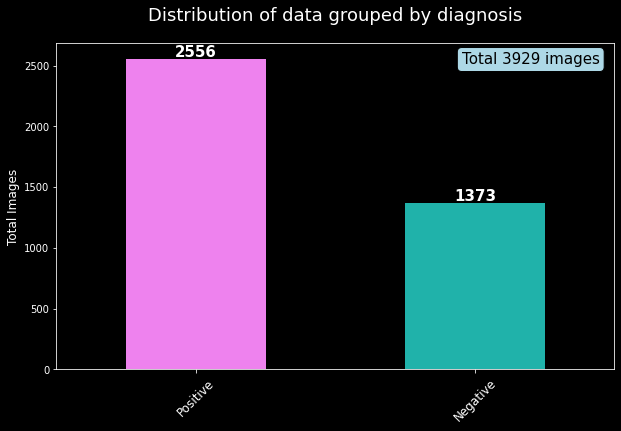

In [6]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Distribution of positive/negative diagnosis between each patient

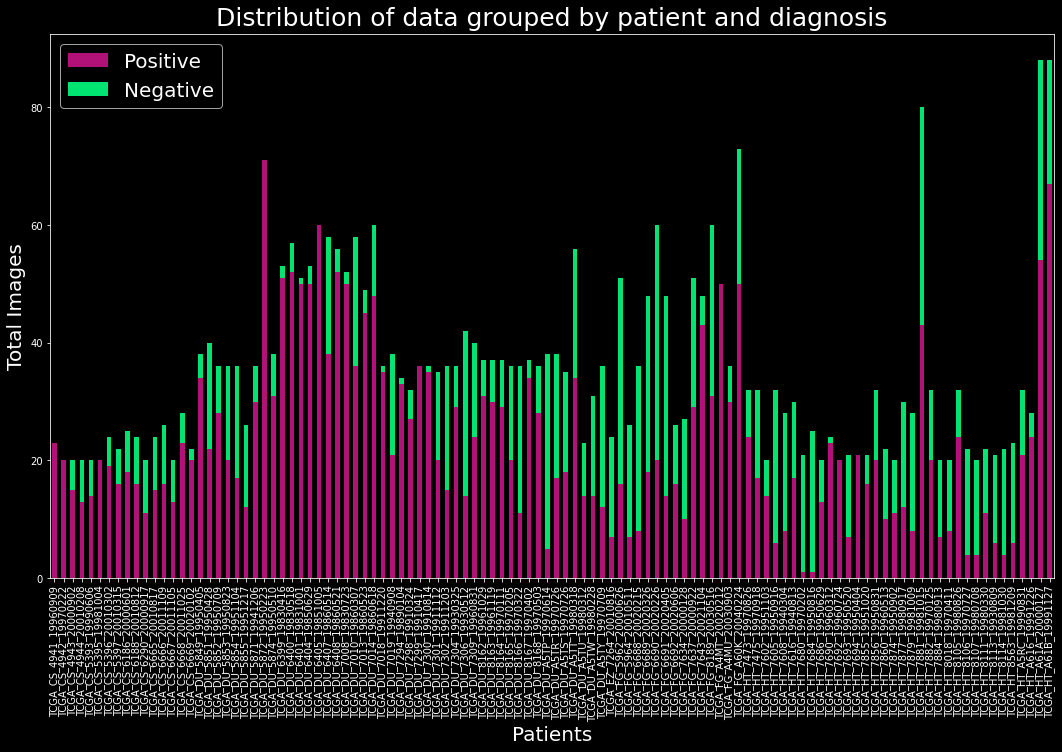

In [7]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Data Visualization

Samples of images with a positive and negative diagnosis

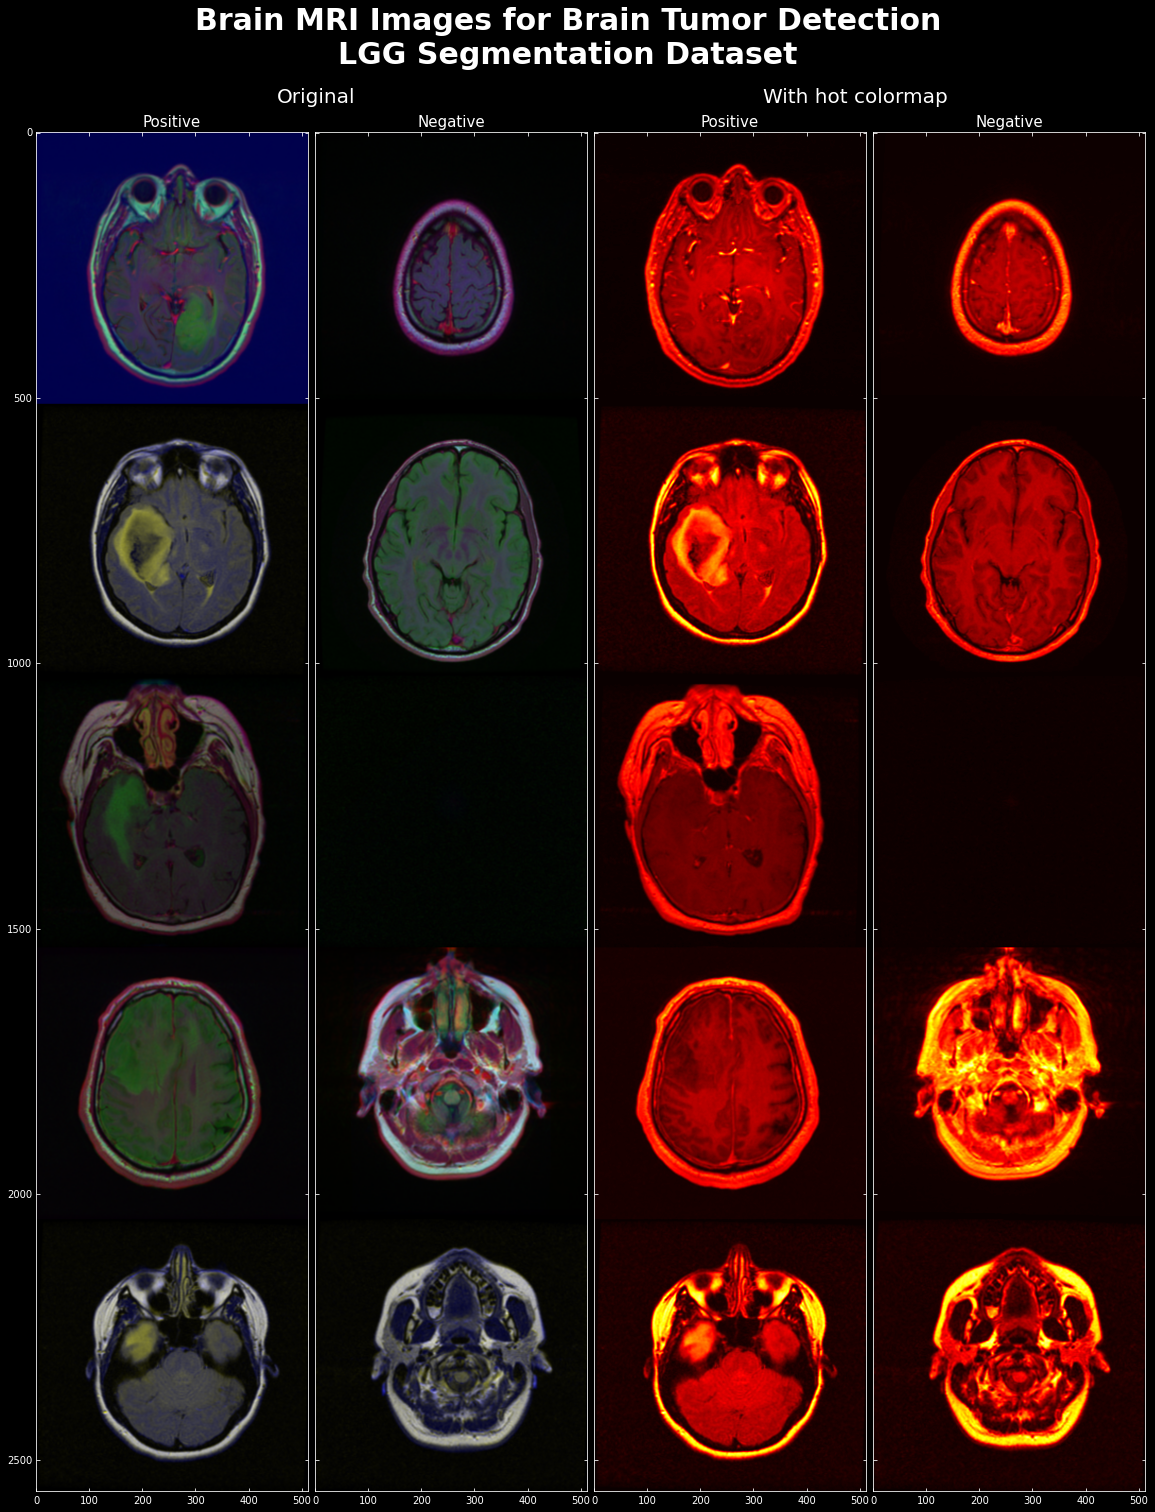

In [8]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

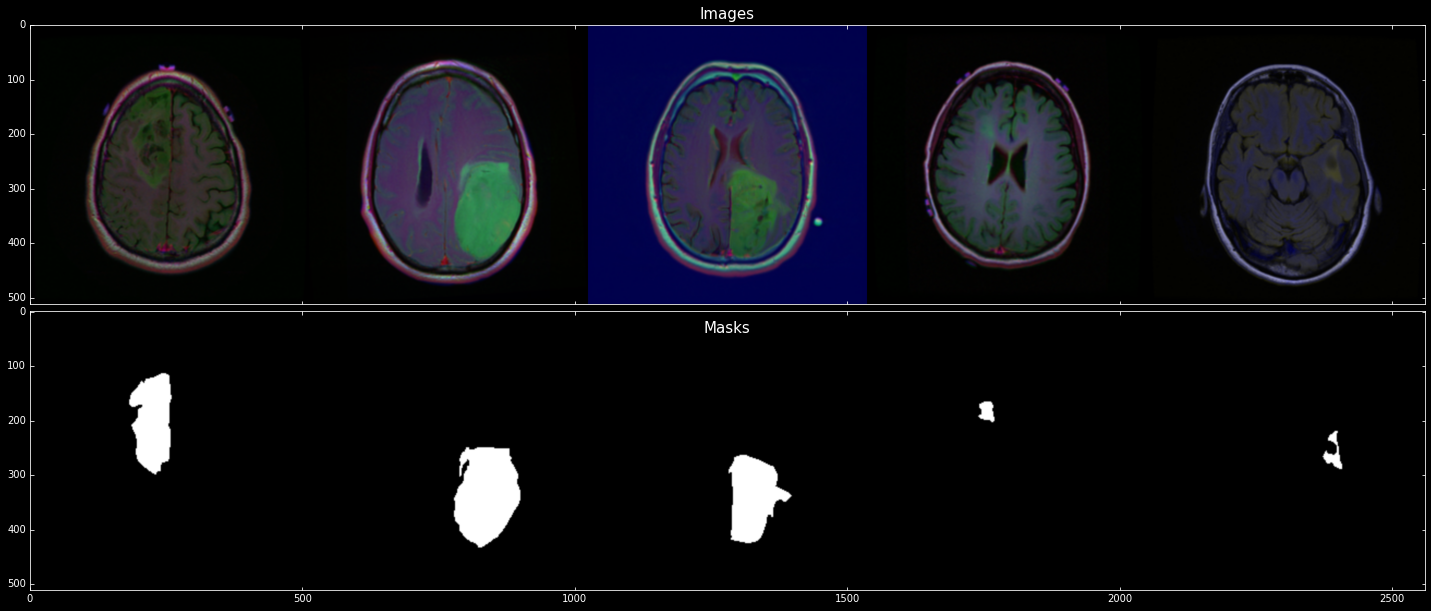

In [9]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

# DataGenerator and Data Augmentation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DataGenerator

In [12]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)

        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)       

transforms

In [13]:
PATCH_SIZE = 128#256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensor(),
])

Split data on train val test

In [14]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [15]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=1, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=1, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=1, shuffle=True)

Augmentation Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


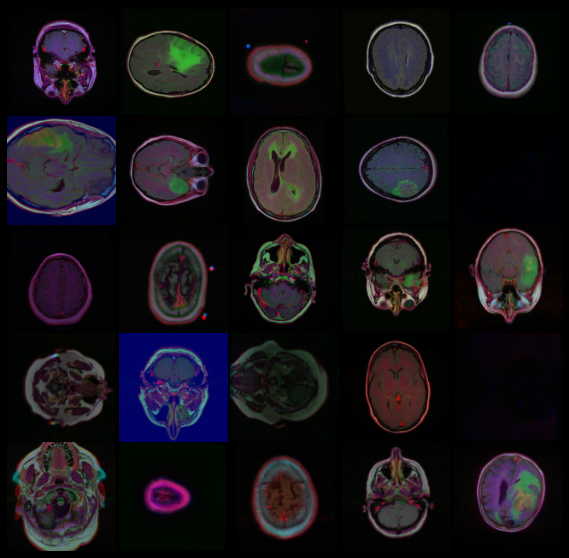

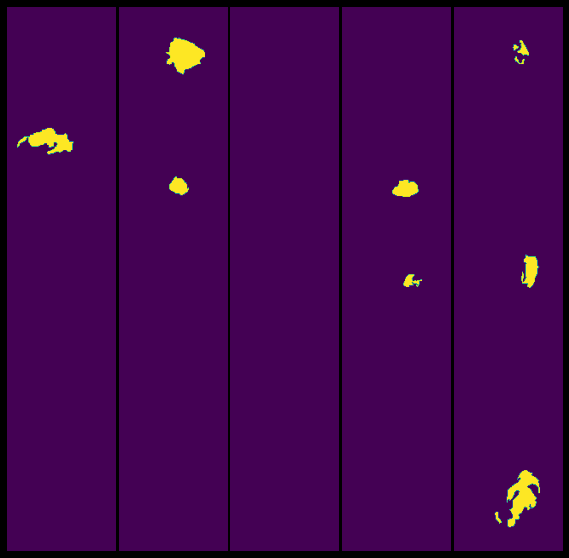

In [16]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

# Model Zoo

## UNet

<p> 
    <img src="https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="650" height="300">
</p>

In [17]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [18]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        
        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)
        
        return out

In [19]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


In [20]:
from torchinfo import summary

summary(unet, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Sequential: 1-1                        [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─ReLU: 2-2                         [1, 64, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 64, 256, 256]         36,928
│    └─ReLU: 2-4                         [1, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─Sequential: 1-3                        [1, 128, 128, 128]        --
│    └─Conv2d: 2-5                       [1, 128, 128, 128]        73,856
│    └─ReLU: 2-6                         [1, 128, 128, 128]        --
│    └─Conv2d: 2-7                       [1, 128, 128, 128]        147,584
│    └─ReLU: 2-8                         [1, 128, 128, 128]        --
├─MaxPool2d: 1-4                         [1, 128, 64, 64]          --

## Feature Pyramid Network + UNet

## FPN 
+ https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610
<p> 
    <img src="https://miro.medium.com/max/2000/1*XOumTDx4QEZ6qd_z1Rgf5g.png">
</p>


## UNet + FPN
+ http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf
<p> 
    <img src="https://user-images.githubusercontent.com/527241/42149076-00cf1d80-7dd5-11e8-94c6-5ac0e79d3b77.png" width="650" height="300">
</p>


In [21]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x



class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [22]:
class FPN(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
         
        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.maxpool = nn.MaxPool2d(2)
        
        # Top layer
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        
        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        
        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4)) 
        
        # Top-down
        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) 
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)
        
        out = torch.sigmoid(out)
        return out

In [23]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [24]:
summary(fpn, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
FPN                                                --                        --
├─ModuleList: 1-1                                  --                        --
├─Sequential: 1-2                                  [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                                 [1, 64, 256, 256]         1,792
│    └─ReLU: 2-2                                   [1, 64, 256, 256]         --
│    └─Conv2d: 2-3                                 [1, 64, 256, 256]         36,928
│    └─ReLU: 2-4                                   [1, 64, 256, 256]         --
├─MaxPool2d: 1-3                                   [1, 64, 128, 128]         --
├─Sequential: 1-4                                  [1, 128, 128, 128]        --
│    └─Conv2d: 2-5                                 [1, 128, 128, 128]        73,856
│    └─ReLU: 2-6                                   [1, 128, 128, 128]        --
│    └─Conv2d: 2-7      

## Unet with ResNeXt50 backbone.

In [25]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [26]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [27]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [28]:
summary(rx50, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
ResNeXtUNet                                   --                        --
├─Sequential: 1-1                             [1, 64, 128, 128]         --
├─ResNet: 1                                   --                        --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
├─Sequential: 1-2                             [1, 256, 128, 128]        --
├─ResNet: 1                                   --                        --
│    └─Sequential: 2                          --                        --
│    │    └─Bottleneck: 3-1                   [1, 256, 128, 128]        63,488
│    │    └─Bottleneck: 3-2                   [1, 256, 128, 128]        71,168
│    │    └─Bottleneck: 3-3                   [1, 256, 128, 128]        71,168
├─Se

# Segmentation Quality Metric

+ https://www.semanticscholar.org/paper/Comparison-of-Jaccard%2C-Dice%2C-Cosine-Similarity-To-Thada-Jaglan/8575e8beef47bd2880c92f54a749f933db983e56

Intuitive interpretation  |  Formula depending on the type of coefficient
:------------------------:|:-------------------------:
![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png) | ![](https://d3i71xaburhd42.cloudfront.net/8575e8beef47bd2880c92f54a749f933db983e56/2-Table1-1.png)



In [29]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

# Segmentation Loss

+ https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8

<p> 
    <img src="https://miro.medium.com/max/1400/0*u6iEAiz9smASIhuk" width="450" height="300">
</p>

In [30]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Train Models

In [31]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    #model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step

In [32]:
# Optimizers
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [34]:
%%time
num_ep = 10                                                                                                  
# Train UNet
unet_lh, unet_th, unet_vh = train_model("Vanila_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20) 

# Train FPN
#fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)#

# Train ResNeXt50
# rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

Vanila_UNet


KeyboardInterrupt: 

## Train history 

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()
    #plt.savefig(fn, bbox_inches='tight', pad_inches=0.2)
    #plt.close()
    

In [ ]:
#plot_model_history("Vanilla UNet", unet_th, unet_vh, 20)
#plot_model_history("FPN", fpn_th, fpn_vh, 20)
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

# Test Prediction

### Test IoU

In [ ]:
#test_iou = compute_iou(unet, test_dataloader)
#print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

#test_iou = compute_iou(fpn, test_dataloader)
#print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

### random test sample

In [ ]:
# image
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

### Predictive overlapping on test images

In [ ]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
    
#prediction_overlap_u = batch_preds_overlap(unet, test_samples)
#prediction_overlap_f = batch_preds_overlap(fpn, test_samples)
prediction_overlap_r = batch_preds_overlap(rx50, test_samples)

## Plates of images of predictive overlapping

In [ ]:
# DATA

# unet plates
#pred_overlap_5x1_u = []
#pred_overlap_5x3_u = []

# fpn plates
#pred_overlap_5x1_f = []
#pred_overlap_5x3_f = []

# rx plates
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    #pred_overlap_5x1_u.append(np.hstack(np.array(prediction_overlap_u[i-5:i])))
    #pred_overlap_5x1_f.append(np.hstack(np.array(prediction_overlap_f[i-5:i])))
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
   #pred_overlap_5x3_u.append(np.vstack(pred_overlap_5x1_u[i-3:i]))
   #pred_overlap_5x3_f.append(np.vstack(pred_overlap_5x1_f[i-3:i]))
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [ ]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

    

title1 = "Predictions of Vanilla UNet"
title2 = "Predictions of FPN"
title3 = "Predictions of UNet with ResNeXt50 backbone"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title3, num)
    

"""for num, (batch1, batch2, batch3) in enumerate(zip(
    pred_overlap_5x3_u, pred_overlap_5x3_f, pred_overlap_5x3_r)):
    
    plot_plate_overlap(batch1,title1, num)   
    plot_plate_overlap(batch2,title2, num)
    plot_plate_overlap(batch3,title3, num)""";

# Gifs

In [ ]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), 
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

#fn1 = make_gif(title1)
#fn2 = make_gif(title2)
fn3 = make_gif(title3)

### Display gifs


In [ ]:
from IPython.display import Image as Image_display

In [ ]:
"""with open(fn1,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

In [ ]:
"""with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))""";

In [ ]:
with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

# What's next?

Experiments:
+  More epochs for training iterations(train longer, without overfitting)
+  Experimenting with different input image size.
+  Experimenting with different batch size.
+  Experimenting with different learning rate.
+  Strong image transforms.
+  Experiments with different UNet backbone
+ Overfits

Fine tuning:
+ Lovasz-Loss
+ lr Schedulers
